# Importing Libraries

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler

# Reading Clean Dataset

In [123]:
data = pd.read_csv("cleaned_dataset.csv")
train_dates = pd.to_datetime(data["Date"])
train_dates = train_dates[7:]
data

,Date,Price
0,1988-08-01,0.8655
1,1988-08-02,0.8600
2,1988-08-03,0.8680
3,1988-08-04,0.8780
4,1988-08-05,0.8870
...,...,...
8883,2023-08-28,3.7920
8884,2023-08-29,3.8390
8885,2023-08-30,3.8440
8886,2023-08-31,3.8220


# Setting Device to GPU

In [124]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# Formatting for LSTM

In [125]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Price(t-{i})'] = df['Price'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Price,Price(t-1),Price(t-2),Price(t-3),Price(t-4),Price(t-5),Price(t-6),Price(t-7)
Date,,,,,,,,
1988-08-10,0.8875,0.8760,0.8710,0.8870,0.8780,0.8680,0.8600,0.8655
1988-08-11,0.9010,0.8875,0.8760,0.8710,0.8870,0.8780,0.8680,0.8600
1988-08-12,0.8835,0.9010,0.8875,0.8760,0.8710,0.8870,0.8780,0.8680
1988-08-15,0.8880,0.8835,0.9010,0.8875,0.8760,0.8710,0.8870,0.8780
1988-08-16,0.8880,0.8880,0.8835,0.9010,0.8875,0.8760,0.8710,0.8870
...,...,...,...,...,...,...,...,...
2023-08-28,3.7920,3.7790,3.7875,3.8305,3.7825,3.7465,3.7060,3.6915
2023-08-29,3.8390,3.7920,3.7790,3.7875,3.8305,3.7825,3.7465,3.7060
2023-08-30,3.8440,3.8390,3.7920,3.7790,3.7875,3.8305,3.7825,3.7465


In [126]:
shifted_df_as_np_before_scaling = shifted_df.to_numpy()
shifted_df_as_np_before_scaling

array([[0.8875, 0.876 , 0.871 , ..., 0.868 , 0.86  , 0.8655],
       [0.901 , 0.8875, 0.876 , ..., 0.878 , 0.868 , 0.86  ],
       [0.8835, 0.901 , 0.8875, ..., 0.887 , 0.878 , 0.868 ],
       ...,
       [3.844 , 3.839 , 3.792 , ..., 3.8305, 3.7825, 3.7465],
       [3.822 , 3.844 , 3.839 , ..., 3.7875, 3.8305, 3.7825],
       [3.8533, 3.822 , 3.844 , ..., 3.779 , 3.7875, 3.8305]])

In [127]:
shifted_df_as_np_before_scaling.shape

(8881, 8)

# Scaling Data

In [128]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(shifted_df_as_np_before_scaling)
shifted_df_as_np = scaler.transform(shifted_df_as_np_before_scaling)
shifted_df_as_np
#shifted_df_as_np

array([[-0.87110187, -0.87641488, -0.87872488, ..., -0.88011088,
        -0.88380688, -0.88126588],
       [-0.86486486, -0.87110187, -0.87641488, ..., -0.87549088,
        -0.88011088, -0.88380688],
       [-0.87294987, -0.86486486, -0.87110187, ..., -0.87133287,
        -0.87549088, -0.88011088],
       ...,
       [ 0.49480249,  0.49249249,  0.47077847, ...,  0.48856549,
         0.46638947,  0.44975745],
       [ 0.48463848,  0.49480249,  0.49249249, ...,  0.46869947,
         0.48856549,  0.46638947],
       [ 0.4990991 ,  0.48463848,  0.49480249, ...,  0.46477246,
         0.46869947,  0.48856549]])

In [129]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((8881, 7), (8881,))

In [130]:
X = dc(np.flip(X, axis=1))
X

array([[-0.88126588, -0.88380688, -0.88011088, ..., -0.87133287,
        -0.87872488, -0.87641488],
       [-0.88380688, -0.88011088, -0.87549088, ..., -0.87872488,
        -0.87641488, -0.87110187],
       [-0.88011088, -0.87549088, -0.87133287, ..., -0.87641488,
        -0.87110187, -0.86486486],
       ...,
       [ 0.44975745,  0.46638947,  0.48856549, ...,  0.46477246,
         0.47077847,  0.49249249],
       [ 0.46638947,  0.48856549,  0.46869947, ...,  0.47077847,
         0.49249249,  0.49480249],
       [ 0.48856549,  0.46869947,  0.46477246, ...,  0.49249249,
         0.49480249,  0.48463848]])

In [131]:
X = X.reshape((-1, lookback, 1))
y = y.reshape((-1, 1))
X.shape,y.shape

((8881, 7, 1), (8881, 1))

In [132]:
X = torch.tensor(X).float()
y = torch.tensor(y).float()

# Preparing LSTM

In [133]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

dataset = TimeSeriesDataset(X, y)

In [134]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [135]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [136]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

# Training and Optimising

In [137]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [138]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [139]:
learning_rate = 0.001
num_epochs = 20
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
"""
Adam does the gradient descent for me
"""
for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.309
Batch 200, Loss: 0.126
Batch 300, Loss: 0.019
Batch 400, Loss: 0.014
Batch 500, Loss: 0.010
Val Loss: 0.007
***************************************************

Epoch: 2
Batch 100, Loss: 0.006
Batch 200, Loss: 0.005
Batch 300, Loss: 0.003
Batch 400, Loss: 0.002
Batch 500, Loss: 0.001
Val Loss: 0.001
***************************************************

Epoch: 3
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001
Batch 400, Loss: 0.001
Batch 500, Loss: 0.001
Val Loss: 0.001
***************************************************

Epoch: 4
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001
Batch 400, Loss: 0.001
Batch 500, Loss: 0.001
Val Loss: 0.001
***************************************************

Epoch: 5
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001
Batch 400, Loss: 0.001
Batch 500, Loss: 0.001
Val Loss: 0.001
***************************************************

Epoch: 6
Batch 100, Loss: 0.001
Bat

# Predicting

In [140]:
start_date = (train_dates.iloc[-1].date()+ timedelta(days=1)).strftime("%Y-%m-%d")
end_date = '2023-12-31'
test_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Create a DataFrame with the date column
testset = pd.DataFrame({'Date': test_dates})
testset['Date'] = pd.to_datetime(testset['Date'])
testset.to_numpy()
testset


,Date
0,2023-09-02
1,2023-09-03
2,2023-09-04
3,2023-09-05
4,2023-09-06
...,...
116,2023-12-27
117,2023-12-28
118,2023-12-29
119,2023-12-30


## Scaling Data

In [141]:
min_data = np.min(shifted_df_as_np_before_scaling)
max_data = np.max(shifted_df_as_np_before_scaling)
scaled_min = np.min(shifted_df_as_np)
scaled_max = np.max(shifted_df_as_np)

In [142]:
# custom scaling works the same way as MinMaxScaling, but MinMaxScaling require numpy with sizes similar to oriinal data, which is not possible
def custom_scaling(data, min_val, max_val):
    global min_data, max_data
    if np.min(data) < min_data:
        min_data = np.min(data)
    else:
        min_data = np.min(shifted_df_as_np_before_scaling)
    if np.max(data) > max_data:
        max_data = np.max(data)
    else:
        max_data = np.max(shifted_df_as_np_before_scaling)
    scaled_data = min_val + ((data - min_data) / (max_data - min_data)) * (max_val - min_val)
    return scaled_data

scaled_min = np.min(shifted_df_as_np)
scaled_max = np.max(shifted_df_as_np)
print(scaled_max)
def reverse_custom_scaling(scaled_data, min_val, max_val):
    global scaled_min, scaled_max
    if np.min(scaled_data) < scaled_min:
        scaled_min = np.min(scaled_data)
    if np.max(scaled_data) > scaled_max:
        scaled_max = np.max(scaled_data)
    original_data = min_data + (((scaled_data - min_val)/(max_val - min_val))*(max_data-min_data))
    return original_data

1.0


In [155]:
for _ in range(test_dates.shape[0]):    
    shifted_df_as_np_before_scaling = shifted_df.to_numpy()
    sample = shifted_df_as_np_before_scaling[-1,1:]
    sample = sample.reshape(1,-1)
    sample_np = np.flip(sample,axis=1)
    sample_np = custom_scaling(sample_np,-1,1)
    sample_np = sample_np.reshape((-1, lookback, 1))
    sample_tensor = torch.tensor(sample_np).float()
    with torch.no_grad():
        predicted = model(sample2_tensor.to(device)).to('cpu').numpy()
    res = reverse_custom_scaling(predicted,-1,1)
    sample2[0][-1]
    new_row = {'Price':res[0][0], 
               'Price(t-1)':shifted_df_as_np_before_scaling[-1][0],
               'Price(t-2)':shifted_df_as_np_before_scaling[-1][1],
               'Price(t-3)':shifted_df_as_np_before_scaling[-1][2],
               'Price(t-4)':shifted_df_as_np_before_scaling[-1][3],
               'Price(t-5)':shifted_df_as_np_before_scaling[-1][4],
               'Price(t-6)':shifted_df_as_np_before_scaling[-1][5],
               'Price(t-7)':shifted_df_as_np_before_scaling[-1][6]
               }
    new_row 
    shifted_df = shifted_df._append(new_row,ignore_index=True)
shifted_df 

,Price,Price(t-1),Price(t-2),Price(t-3),Price(t-4),Price(t-5),Price(t-6),Price(t-7)
0,0.887500,0.876000,0.871000,0.887000,0.878000,0.868000,0.860000,0.865500
1,0.901000,0.887500,0.876000,0.871000,0.887000,0.878000,0.868000,0.860000
2,0.883500,0.901000,0.887500,0.876000,0.871000,0.887000,0.878000,0.868000
3,0.888000,0.883500,0.901000,0.887500,0.876000,0.871000,0.887000,0.878000
4,0.888000,0.888000,0.883500,0.901000,0.887500,0.876000,0.871000,0.887000
...,...,...,...,...,...,...,...,...
9118,3.601756,3.601756,3.601756,3.601756,3.601756,3.601756,3.601756,3.601756
9119,3.601756,3.601756,3.601756,3.601756,3.601756,3.601756,3.601756,3.601756
9120,3.601756,3.601756,3.601756,3.601756,3.601756,3.601756,3.601756,3.601756
9121,3.601756,3.601756,3.601756,3.601756,3.601756,3.601756,3.601756,3.601756


In [152]:
testset
temp = shifted_df.tail(125)["Price"]
new_set = pd.DataFrame(columns=["Date","Price"]) 
for i in range(test_dates.shape[0]):
    item = {"Date":test_dates[i].date(), "Price": temp.iloc[i]}
    new_set = new_set._append(item, ignore_index=True)

new_set["Date"] = pd.to_datetime(new_set["Date"])
new_set.sort_values(by="Date",ascending=True)
new_set

,Date,Price
0,2023-09-02,3.839000
1,2023-09-03,3.844000
2,2023-09-04,3.822000
3,2023-09-05,3.853300
4,2023-09-06,3.821223
...,...,...
116,2023-12-27,3.619998
117,2023-12-28,3.617750
118,2023-12-29,3.615493
119,2023-12-30,3.613227


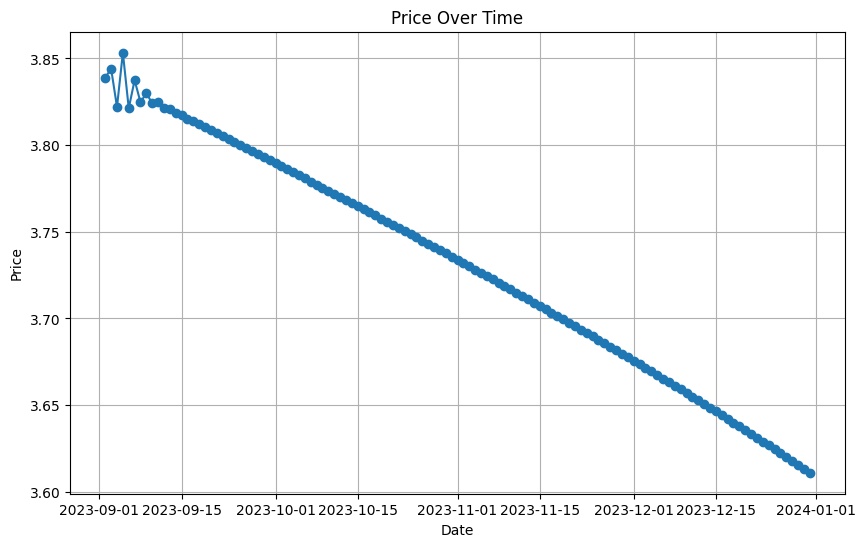

In [153]:
plt.figure(figsize=(10, 6))

plt.plot(new_set["Date"], new_set["Price"], marker='o')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Over Time')
plt.grid(True)
plt.show()

# Plotting Everything

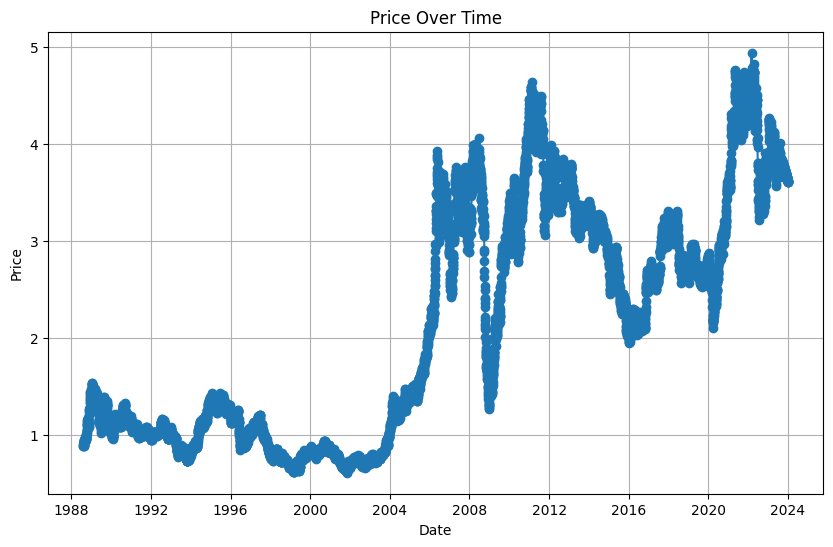

In [154]:
wholeset = pd.DataFrame()
wholeset = pd.concat([train_dates[:],new_set["Date"]],axis=0)
wholeset = pd.to_datetime(wholeset)

plt.figure(figsize=(10, 6))

plt.plot(wholeset,shifted_df['Price'], marker='o')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Over Time')
plt.grid(True)
plt.show()